# Integration with pandas

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext version_information
%version_information numpy, matplotlib, pandas

Software versions
Python 3.5.2 64bit [MSC v.1900 64 bit (AMD64)]
IPython 5.3.0
OS Windows 10 10.0.14393 SP0
numpy 1.11.3
matplotlib 2.0.0
pandas 0.19.2
Wed May 17 12:06:42 2017 Hora de verano romance

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
import shutil

matplotlib.rcParams.update({'font.size': 12})

## Load pokemon dataset

In [3]:
%%time
df = pd.read_csv('pokemon/300k_csv.zip')
# Replace ? by a float representation
df['pokestopDistanceKm'].replace({'?': 999.9}, inplace=True)
df['pokestopDistanceKm'] = df.pokestopDistanceKm.astype(float)
# Rename column with reserved name class by target
df.rename(columns={'class': 'target'}, inplace=True)

<string>:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 10 s


## Storing in HDF5 compressed form with pandas.HDFStore

In [4]:
data_dir = "hdfstore"
if os.path.exists(data_dir):
    shutil.rmtree(data_dir)
os.mkdir(data_dir)

In [5]:
%%time
complib = 'blosc:zstd'
complevel = 6
filename = "%s/%s-%d.h5" % (data_dir, complib, complevel)
with pd.HDFStore(filename, mode='w') as hdf:
    # We only index the columns needed
    hdf.put(key='d1', value=df, data_columns=['target', 'latitude', 'longitude'], format='table', complevel=complevel, complib=complib)

Wall time: 12.2 s


## Select comparison: Memory VS Disk

In [6]:
%%time
df2 = df[(41.365 < df.latitude) & (df.latitude < 41.383) & 
         (2.175 < df.longitude) & (df.longitude < 2.196)]

Wall time: 9.01 ms


In [7]:
%%time
with pd.HDFStore(filename, mode='r') as hdf:
    df2 = hdf.select(key='d1', where='(latitude > 41.365) & (latitude < 41.383) & (longitude > 2.175) & (longitude < 2.196)')

Wall time: 118 ms


## Exercise 1
Compare the time cost of selecting on the pandas DataFrame (consider also the time loading the whole csv) and the time cost of selecting directly from the HDF5 file.  
Also compare the file size of both, the compressed csv and the compressed HDF5 files.

**Optional**: store the csv in an HDF5 file using complib **blosc:lz4** and complevel **9**. Compare the results.

In [8]:
%%time
pd.read_csv('pokemon/300k_csv.zip')
df2 = df[(41.365 < df.latitude) & (df.latitude < 41.383) & 
         (2.175 < df.longitude) & (df.longitude < 2.196)]

Wall time: 9.66 s


<string>:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.


In [9]:
%%time
df2 = df[(41.365 < df.latitude) & (df.latitude < 41.383) & 
         (2.175 < df.longitude) & (df.longitude < 2.196)]

Wall time: 8.01 ms


In [10]:
%%time
with pd.HDFStore(filename, mode='r') as hdf:
    df2 = hdf.select(key='d1', where='(latitude > 41.365) & (latitude < 41.383) & (longitude > 2.175) & (longitude < 2.196)')

Wall time: 123 ms


In [11]:
%%time
complib = 'blosc:lz4'
complevel = 9
filename = "%s/%s-%d.h5" % (data_dir, complib, complevel)
with pd.HDFStore(filename, mode='w') as hdf:
    # We only index the columns needed
    hdf.put(key='d1', value=df, data_columns=['target', 'latitude', 'longitude'], format='table', complevel=complevel, complib=complib)

Wall time: 4.44 s


In [12]:
%%time
with pd.HDFStore(filename, mode='r') as hdf:
    df2 = hdf.select(key='d1', where='(latitude > 41.365) & (latitude < 41.383) & (longitude > 2.175) & (longitude < 2.196)')

Wall time: 92.1 ms


## Plotting Barcelona Pokemon's

In [13]:
def plot_pokemons(df, extent, detail_level):
        
    tiler = cimgt.OSM()
    fig, ax = plt.subplots(figsize=(25, 20), 
                           subplot_kw=dict(projection=tiler.crs))
    # Grid and limits
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    ax.set_extent(extent)
    # Tiler image and detail level
    ax.add_image(tiler, detail_level) # always use low detail level during exploration
    # Point transformation from cartopy to matplotlib
    crs = ccrs.Geodetic()
    transform = crs._as_mpl_transform(ax)
    # Mapping points to Pokemon sprites
    x, y, targets = df.longitude.values, df.latitude.values, df.target.values
    artists = []
    for i in range(df.shape[0]):
        image = plt.imread('pokemon/sprites/' + str(targets[i]) + '.png')
        im = OffsetImage(image, zoom=0.6)
        ab = AnnotationBbox(im, (x[i], y[i]), xycoords=transform, frameon=False)
        artists.append(ax.add_artist(ab))
    ax.plot(x, y, 'ob')

    plt.show()

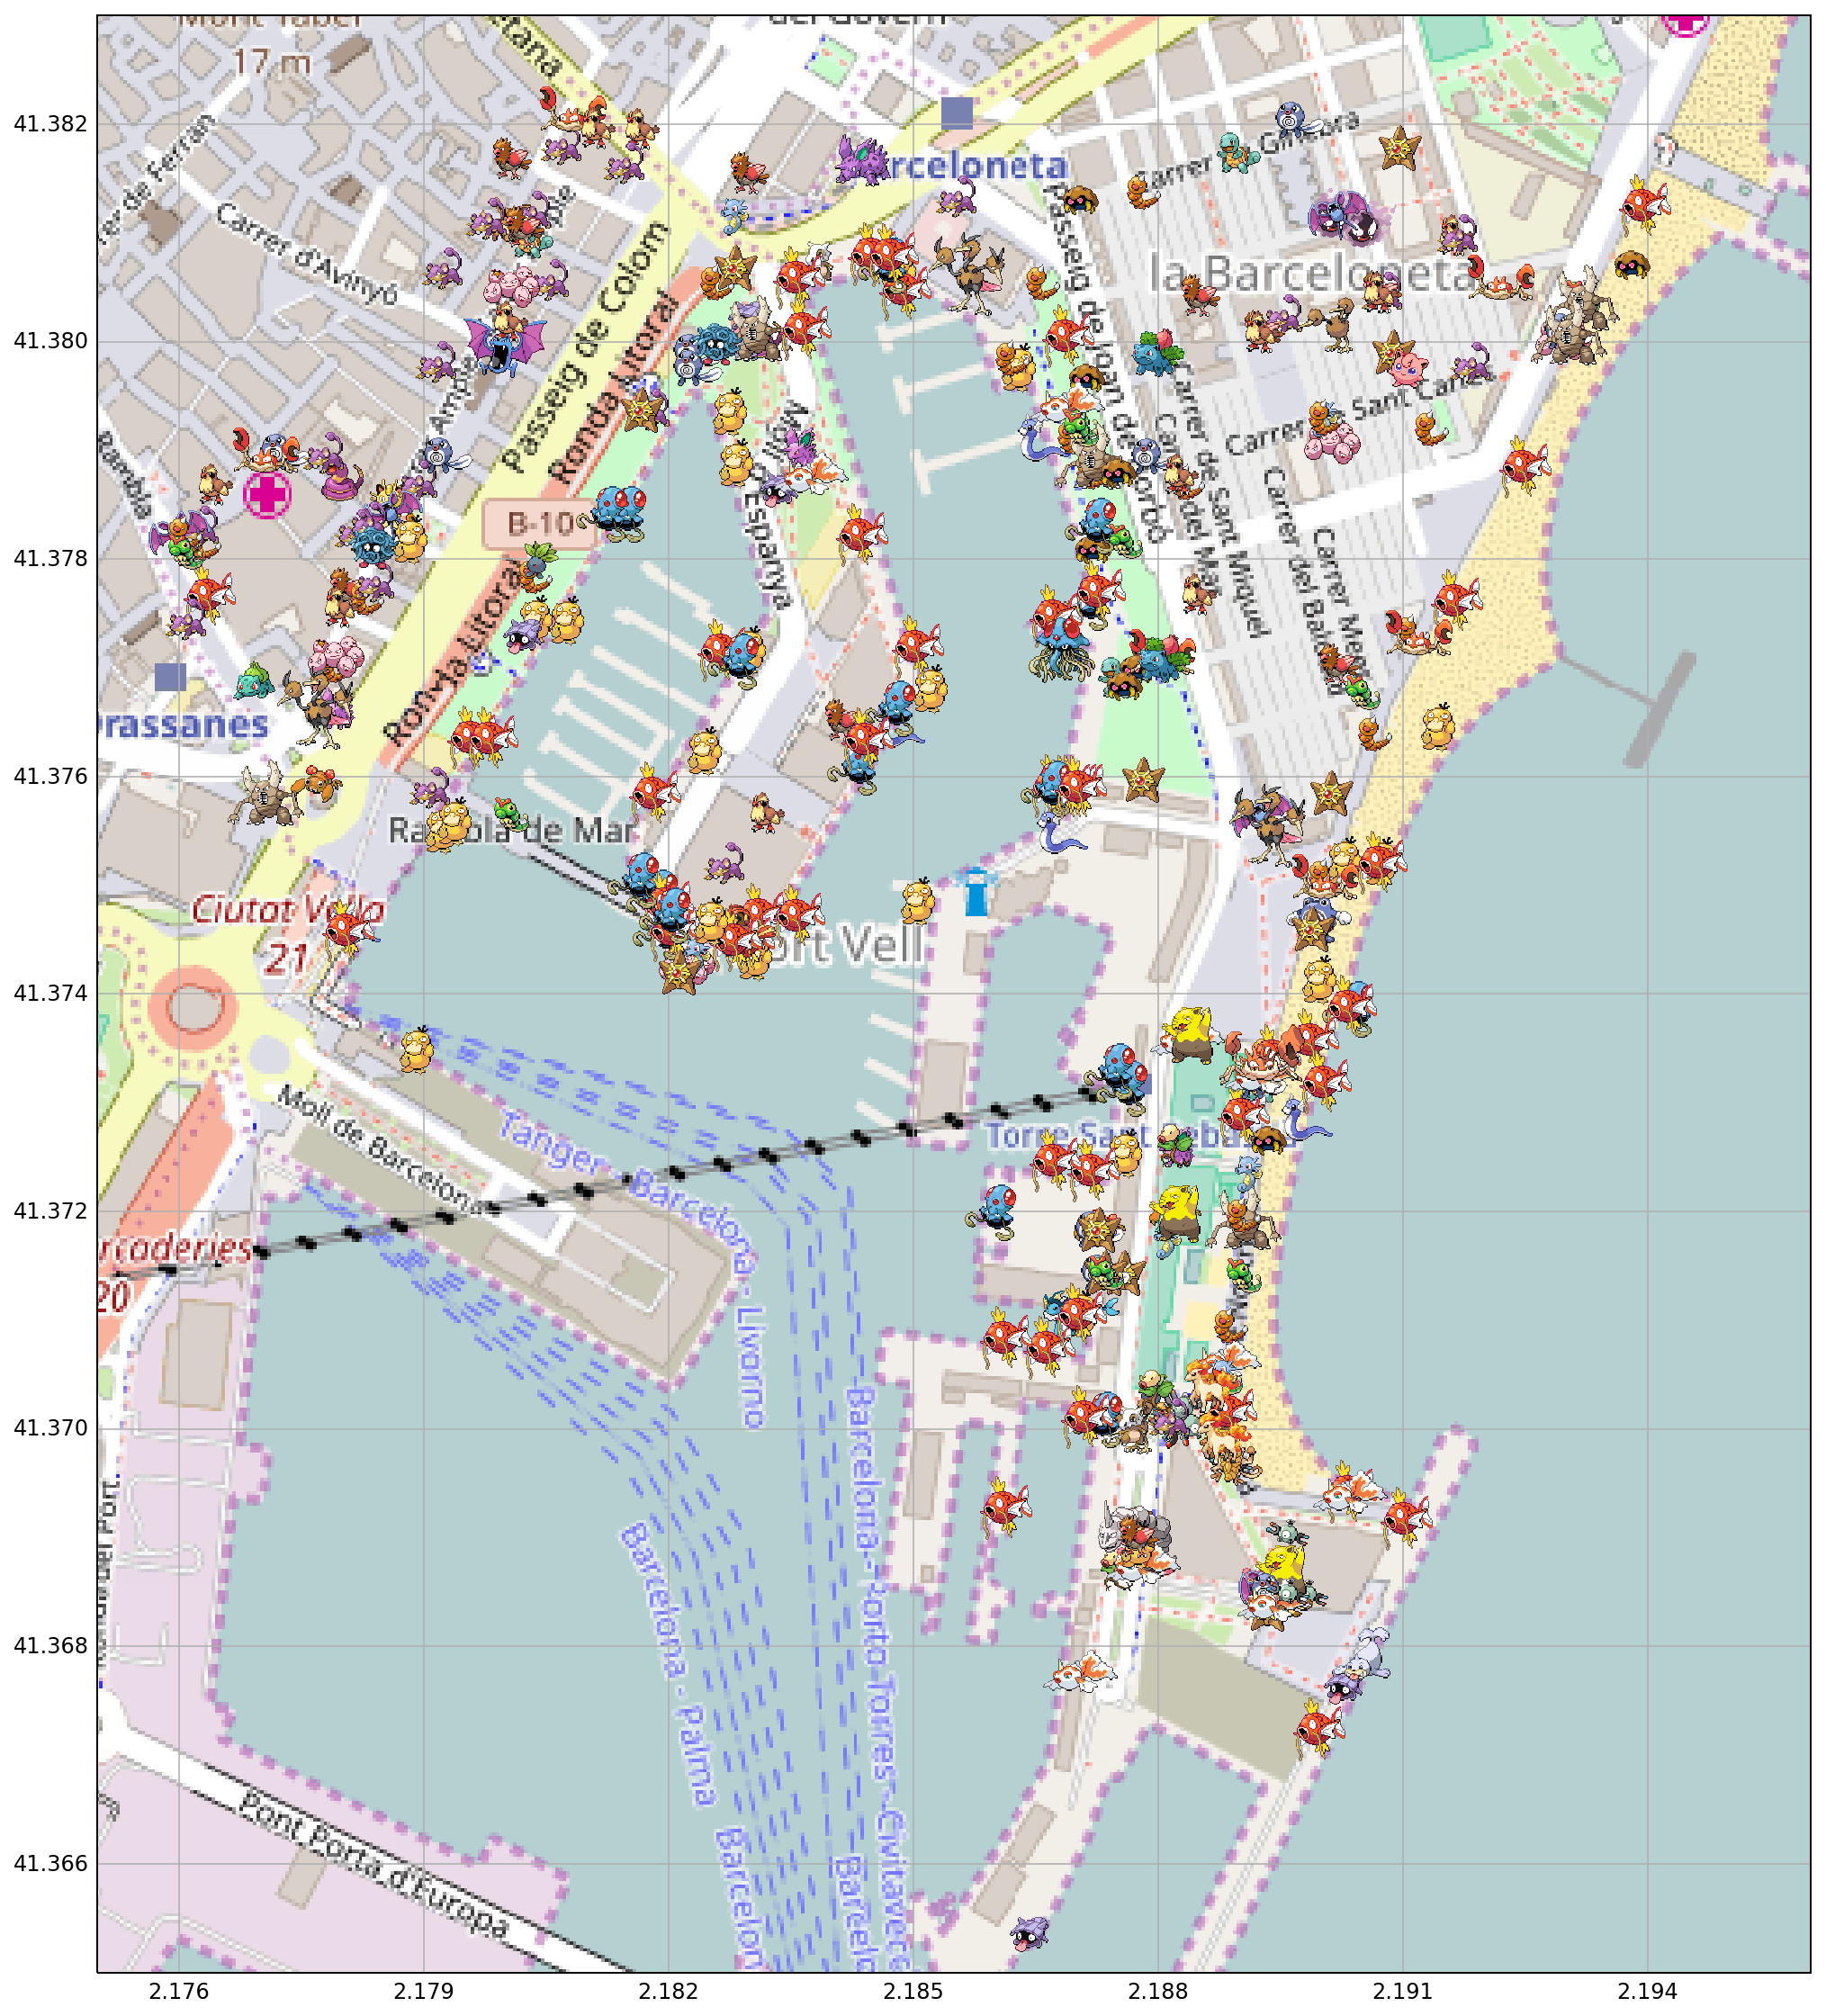

Wall time: 12.2 s


In [14]:
%%time
with pd.HDFStore(filename, mode='r') as hdf:
    df2 = hdf.select(key='d1', where='(latitude > 41.365) & (latitude < 41.383) & (longitude > 2.175) & (longitude < 2.196)')
extent = (2.175, 2.196, 41.365, 41.383)
detail_level = 15
plot_pokemons(df2, extent, detail_level)

### Exercise 1
Plot the pokemon in Central Park, New York.  
Warning: Start using low **detail_level** such as 4-10  
Tip: http://www.bufa.es/google-maps-latitud-longitud/

In [15]:
with pd.HDFStore(filename, mode='r') as hdf:    
    df2 = hdf.select(key='d1', where='(latitude > 40.764) & (latitude < 40.786) & (longitude > -73.982) & (longitude < -73.96)')

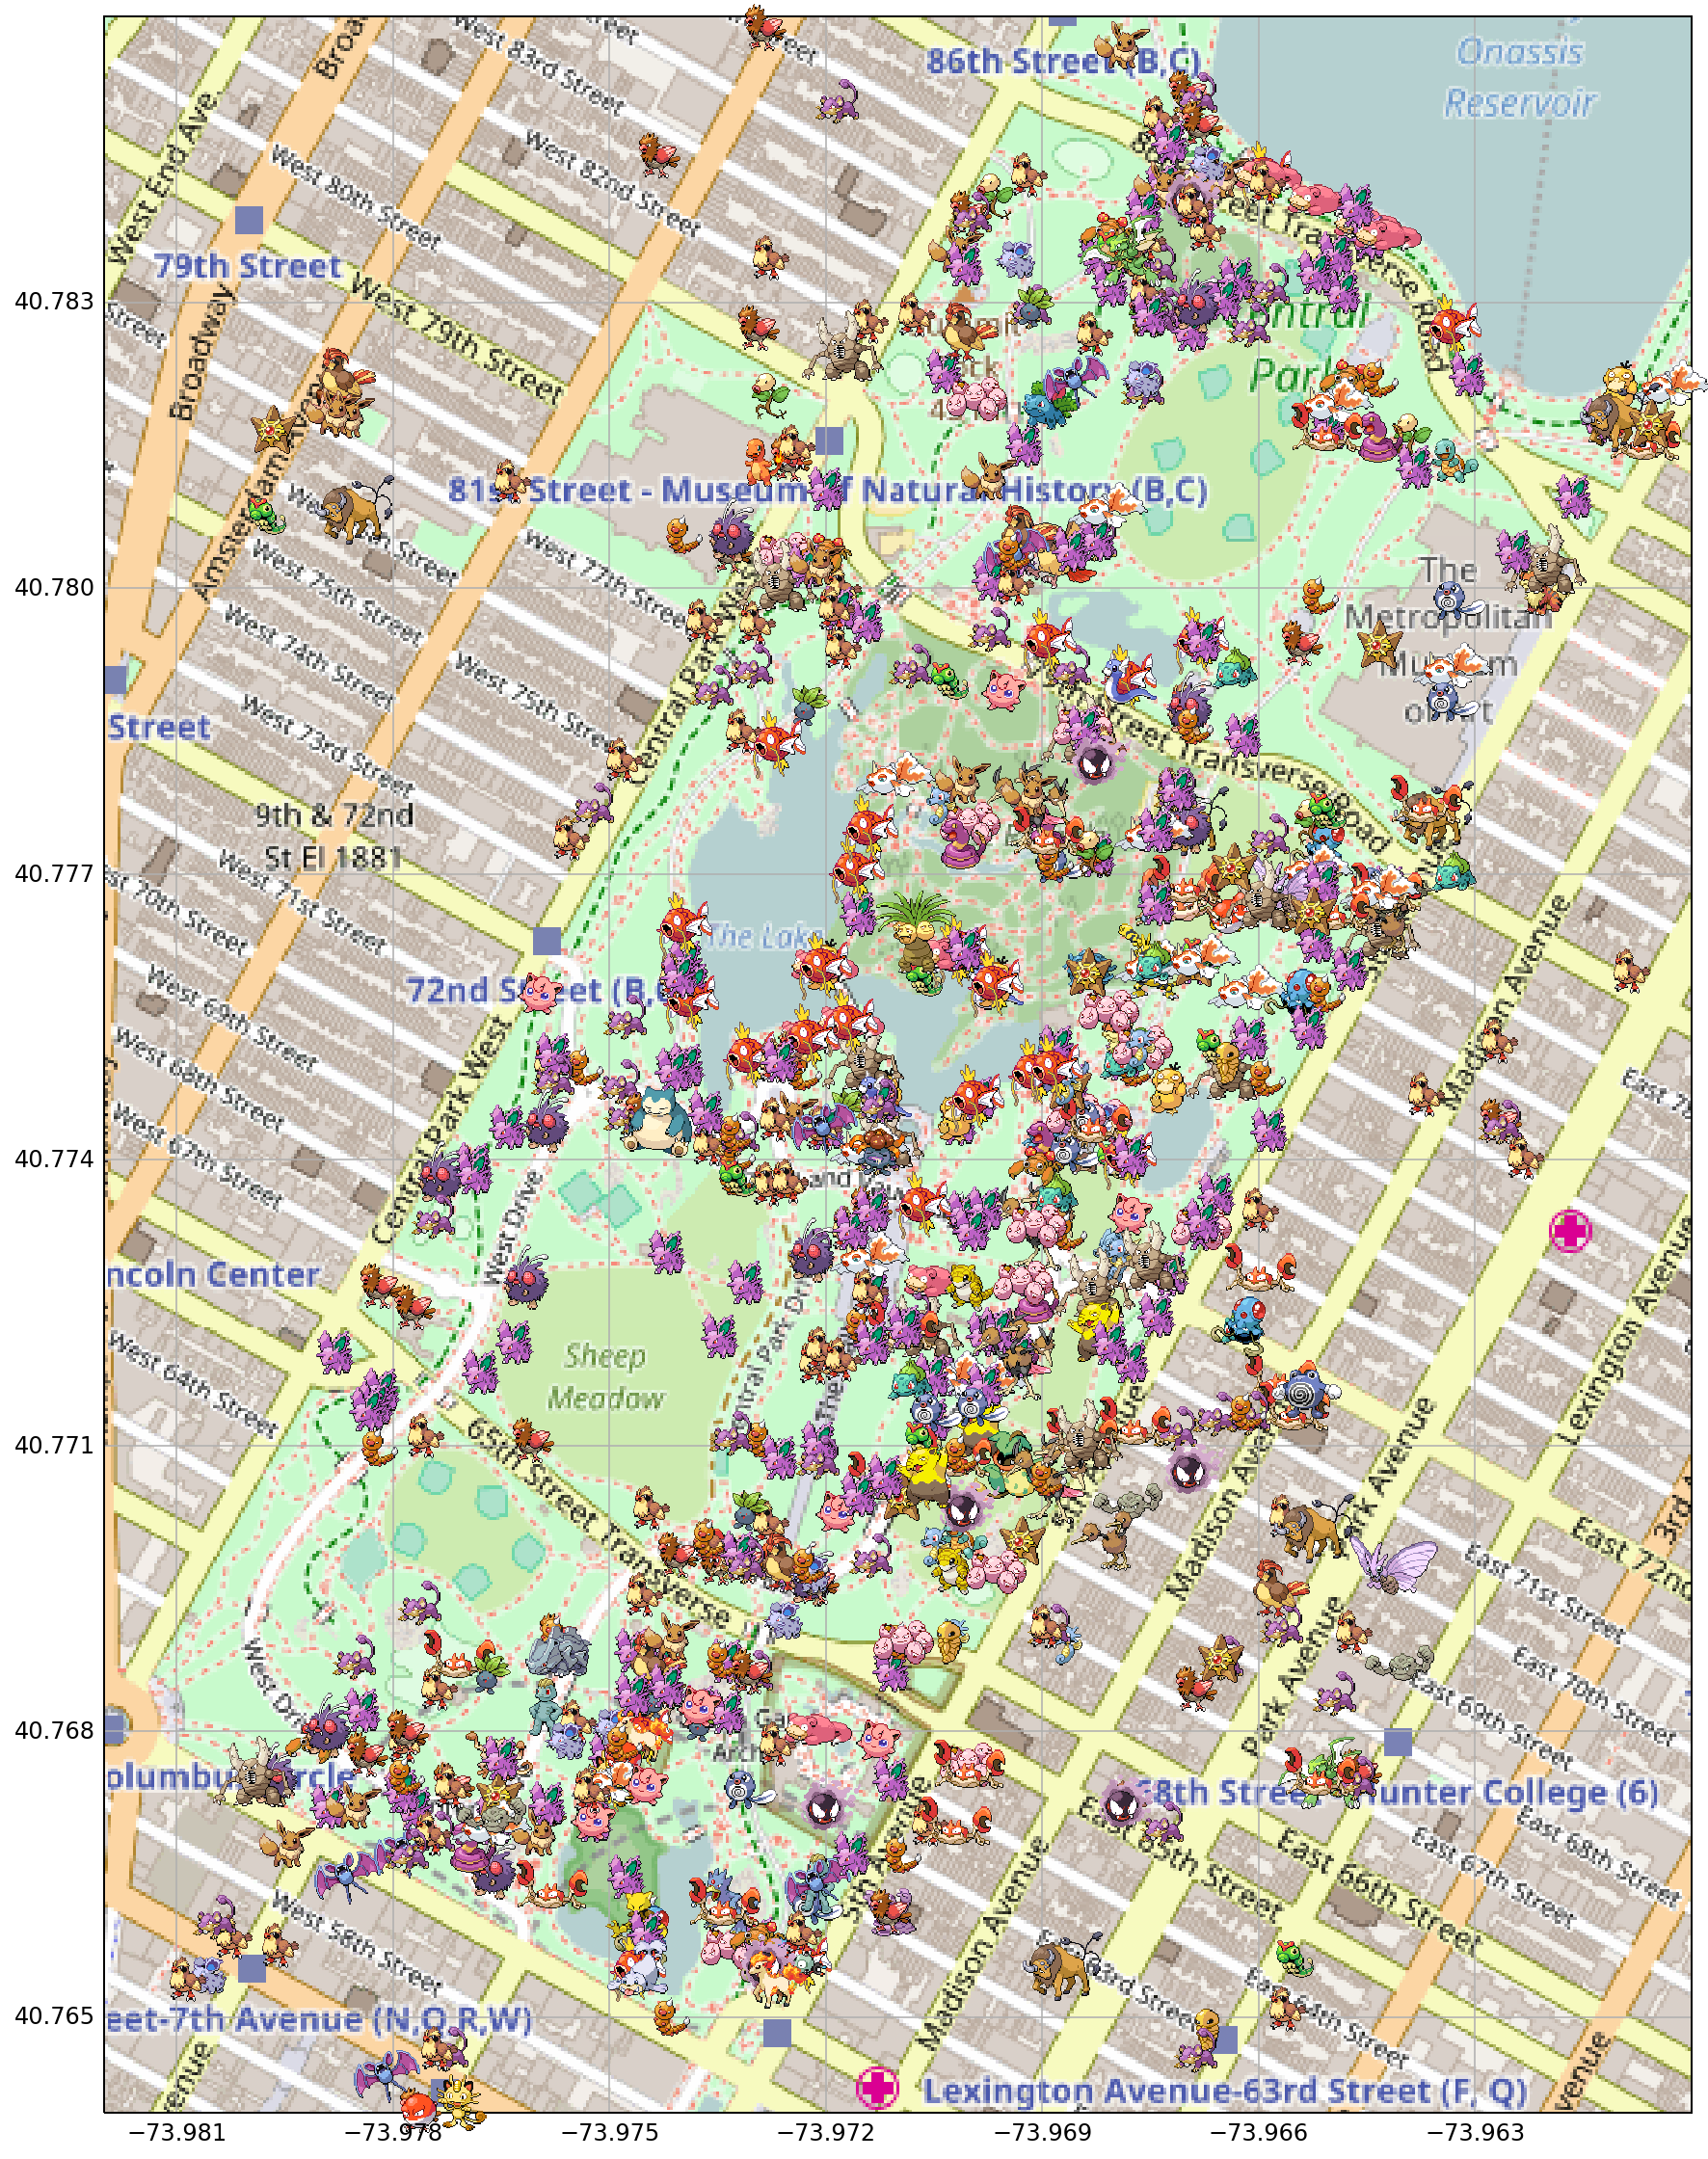

In [16]:
extent = (-73.982, -73.96, 40.764, 40.786)
detail_level = 15
plot_pokemons(df2, extent, detail_level)

### Exercise 2
There are some pokemon which are region exclusive, these are Farfetch'd (**target**=83), Kangashkan (**target**=115), Mr. Mime (**target**=122) and Tauros (**target**=128).  
Plot the world map with only these pokemon.  
**Tip**: edit the function plot_pokemons or create a copy  
Replace the following lines  
```python
tiler = cimgt.OSM()
fig, ax = plt.subplots(figsize=(25, 20), 
                       subplot_kw=dict(projection=tiler.crs))
# Grid and limits
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
ax.set_extent(extent)
# Tiler image and detail level
ax.add_image(tiler, detail_level) # always use low detail level during exploration
```
for
```python
fig, ax = fig, ax = plt.subplots(figsize=(25, 20), 
                           subplot_kw=dict(projection=ccrs.Mollweide()))
ax.stock_img()
```
.

In [17]:
with pd.HDFStore(filename, mode='r') as hdf: 
    df2 = hdf.select(key='d1', where='target=[122,128,115,83]')

In [18]:
def plot_pokemons(df, extent=None, detail_level=1, world_mode=False):
    
    if world_mode:
        fig, ax = fig, ax = plt.subplots(figsize=(25, 20), 
                           subplot_kw=dict(projection=ccrs.Mollweide()))
        ax.stock_img()
    else:
        tiler = cimgt.OSM()
        fig, ax = plt.subplots(figsize=(25, 20), 
                               subplot_kw=dict(projection=tiler.crs))
        # Grid and limits
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        ax.set_extent(extent)
        # Tiler image and detail level
        ax.add_image(tiler, detail_level) # always use low detail level during exploration
    # Point transformation from cartopy to matplotlib
    crs = ccrs.Geodetic()
    transform = crs._as_mpl_transform(ax)
    # Mapping points to Pokemon sprites
    x, y, targets = df.longitude.values, df.latitude.values, df.target.values
    artists = []
    for i in range(df.shape[0]):
        image = plt.imread('pokemon/sprites/' + str(targets[i]) + '.png')
        im = OffsetImage(image, zoom=0.6)
        ab = AnnotationBbox(im, (x[i], y[i]), xycoords=transform, frameon=False)
        artists.append(ax.add_artist(ab))
    ax.plot(x, y, 'ob')

    plt.show()

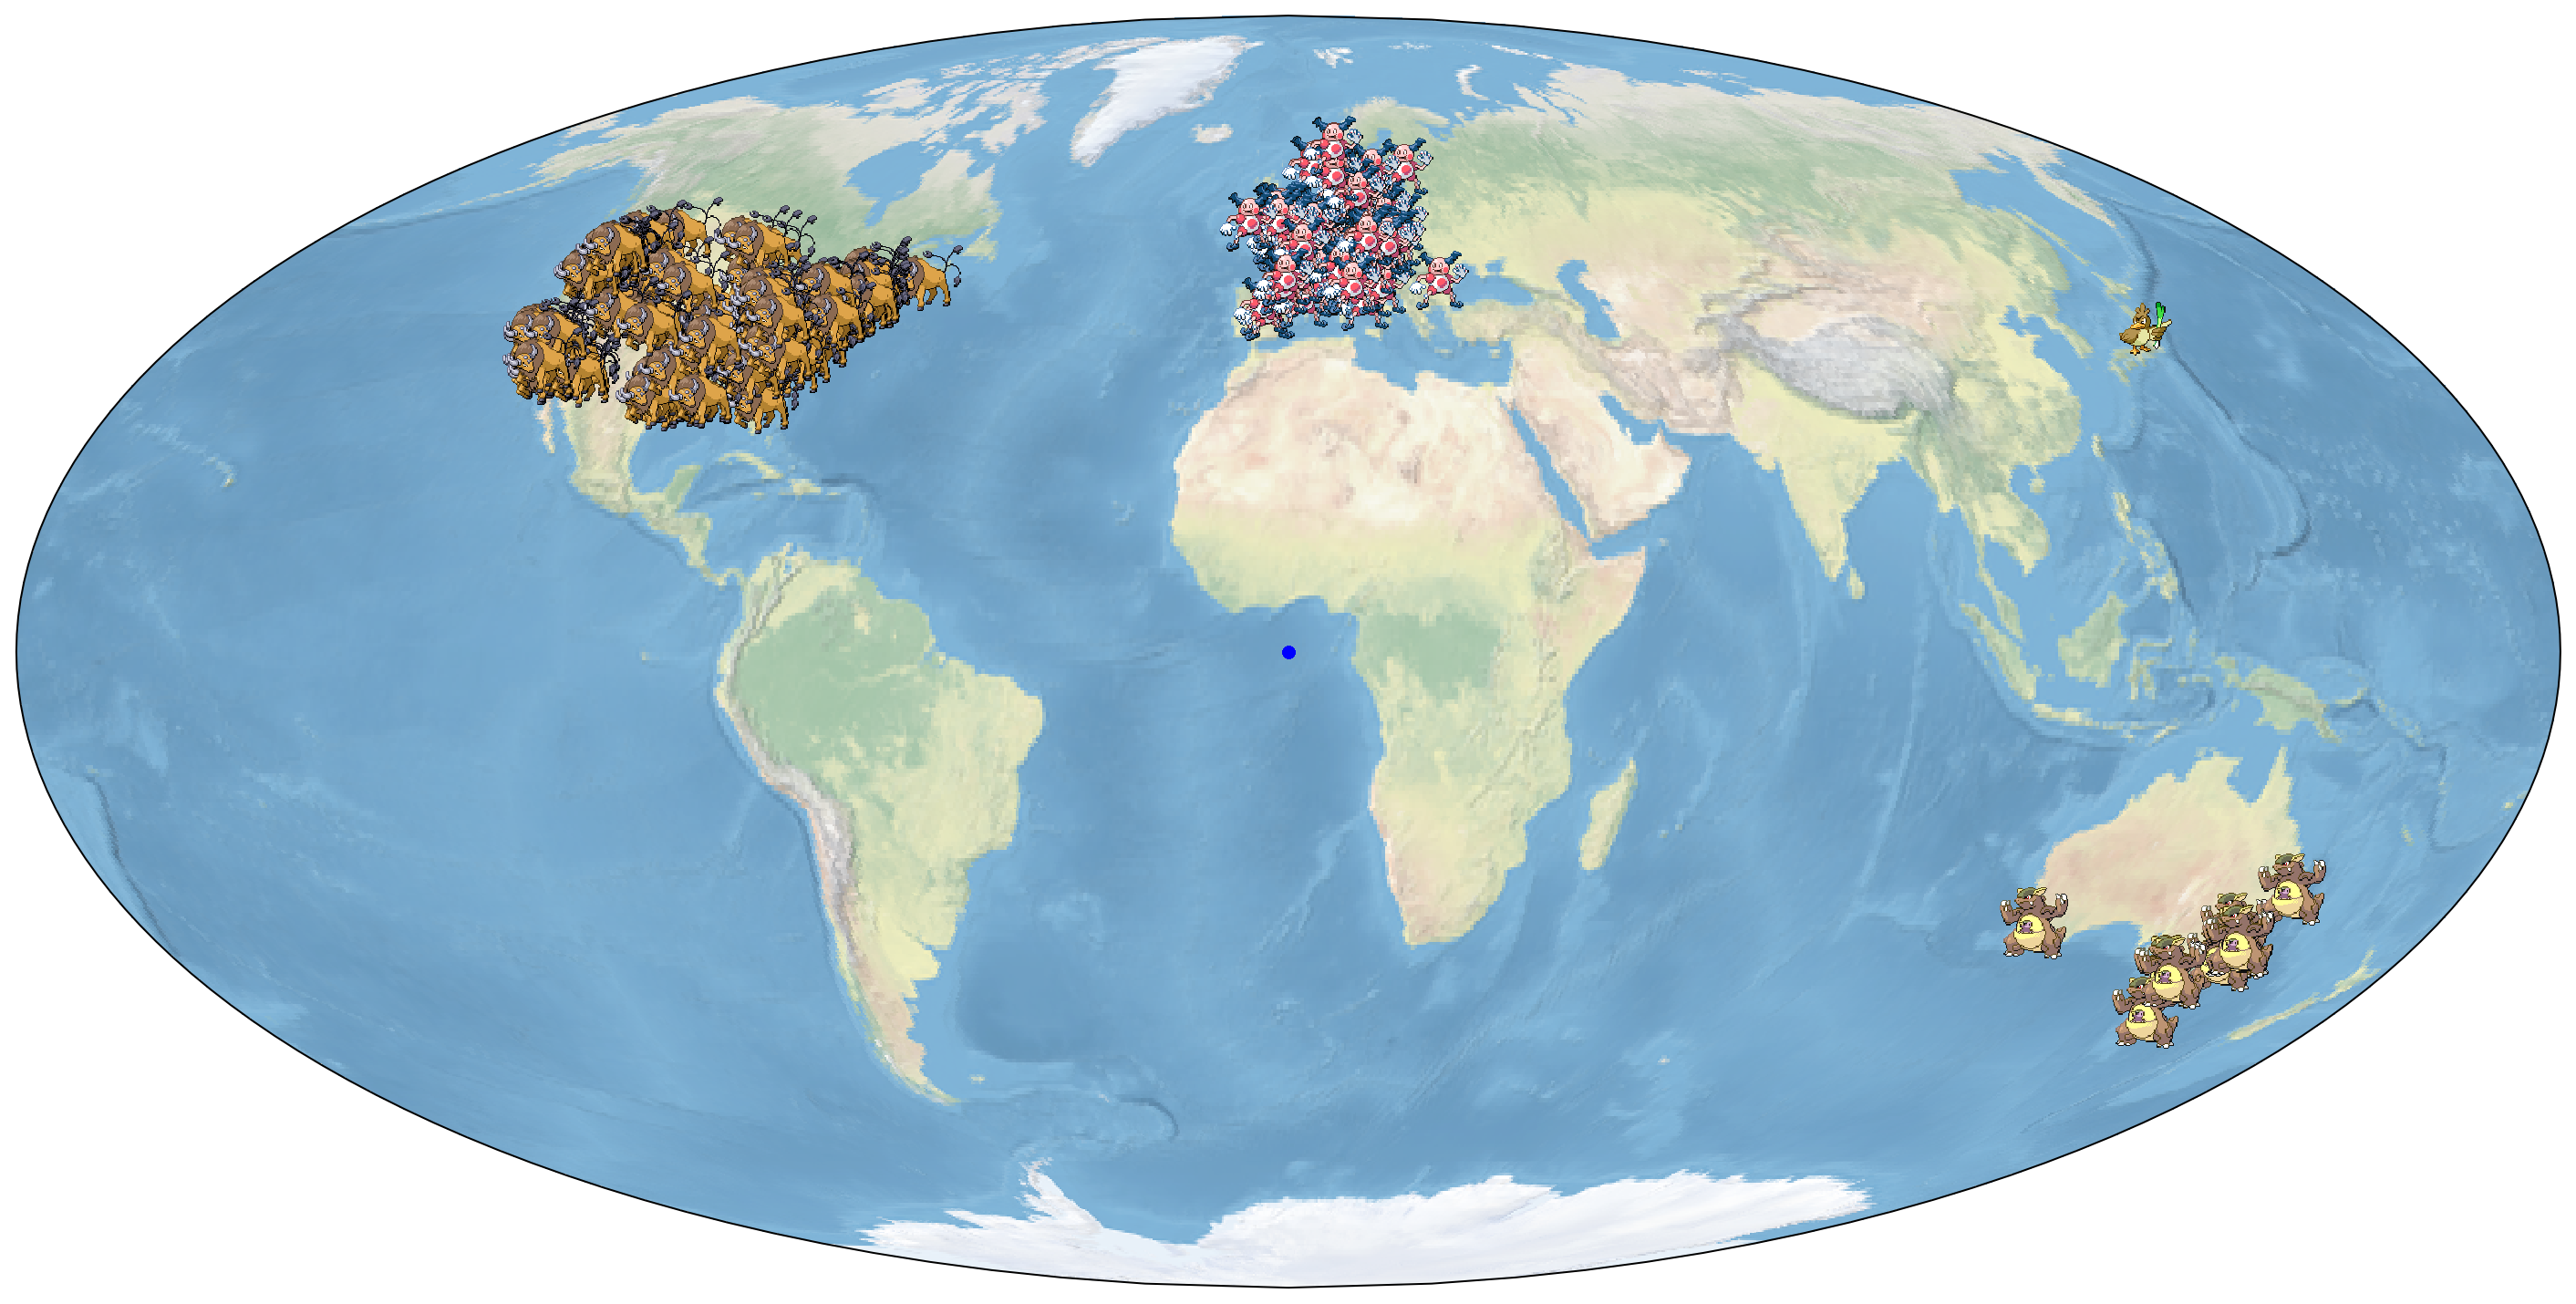

In [19]:
plot_pokemons(df2, world_mode=True)